In [1]:
%reset -s -f

In [18]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [22]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df.head(2)
df = df[np.isfinite(df.rgdppc_2000)]
df.head(2)
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df.head(2)

,cont_africa,rugged,rgdppc_2000
0,0,0.462,NaN
1,0,2.518,NaN


,cont_africa,rugged,rgdppc_2000
2,1,0.858,1794.729
4,0,3.427,3703.113


,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929


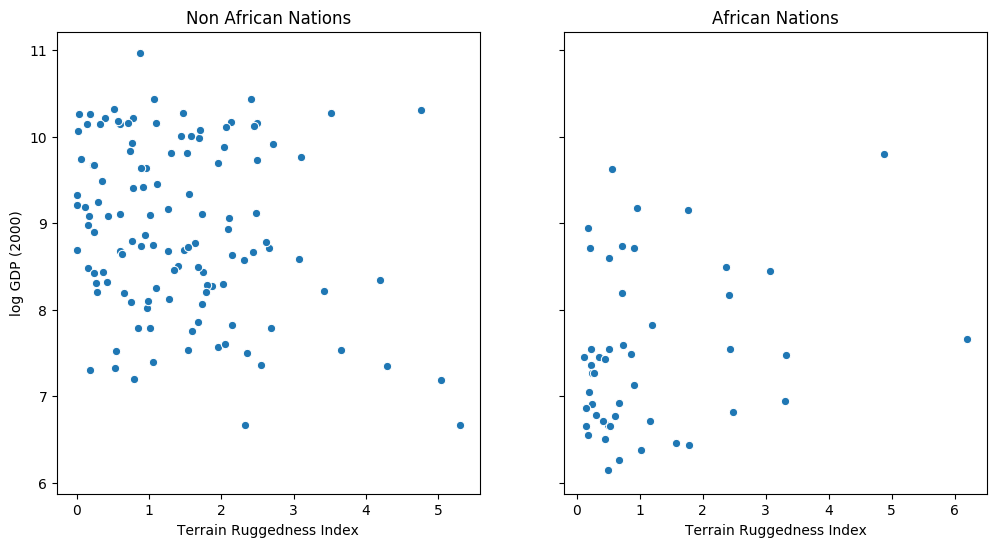

In [24]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [25]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [26]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3179.7852
[iteration 0100] loss: 1616.1372
[iteration 0150] loss: 1109.4120
[iteration 0200] loss: 833.7545
[iteration 0250] loss: 637.5822
[iteration 0300] loss: 488.2652
[iteration 0350] loss: 376.4650
[iteration 0400] loss: 296.0484
[iteration 0450] loss: 240.6140
[iteration 0500] loss: 203.9386
[iteration 0550] loss: 180.6171
[iteration 0600] loss: 166.3494
[iteration 0650] loss: 157.9457
[iteration 0700] loss: 153.1786
[iteration 0750] loss: 150.5735
[iteration 0800] loss: 149.2020
[iteration 0850] loss: 148.5065
[iteration 0900] loss: 148.1668
[iteration 0950] loss: 148.0070
[iteration 1000] loss: 147.9347
[iteration 1050] loss: 147.9032
[iteration 1100] loss: 147.8900
[iteration 1150] loss: 147.8847
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8815
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94785

In [27]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()
fit

,cont_africa,rugged,rgdppc_2000,cont_africa_x_rugged,mean
2,1,0.858,7.492609,0.858,7.438684
4,0,3.427,8.216929,0.000,8.528131
7,0,0.769,9.933263,0.000,9.067137
8,0,0.775,9.407032,0.000,9.065920
9,0,2.688,7.792343,0.000,8.677990
...,...,...,...,...,...
229,0,1.677,8.488849,0.000,8.883007
230,0,2.323,6.669180,0.000,8.752007
231,1,1.761,9.150497,1.761,7.610720
232,1,0.533,6.651585,0.533,7.376766


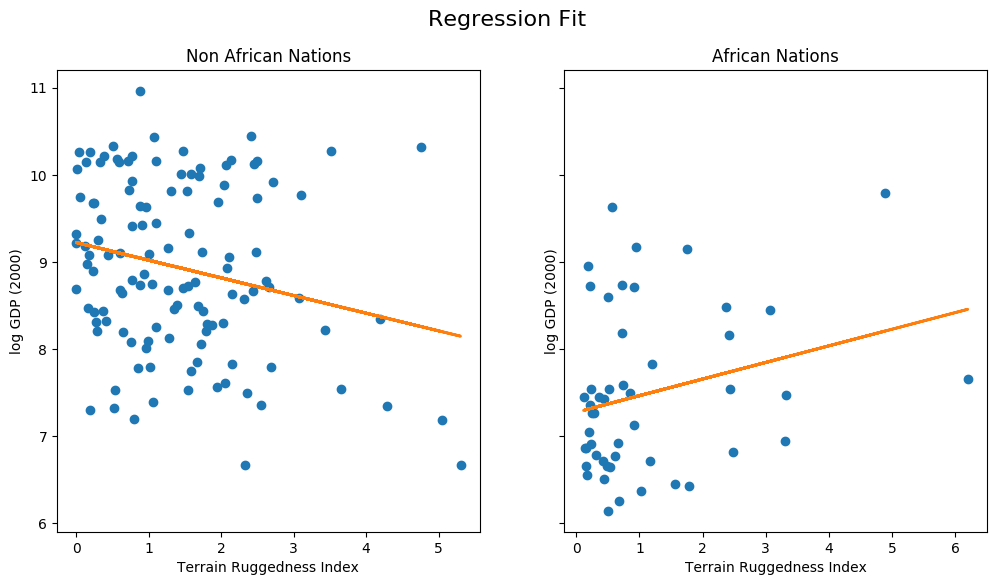

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [28]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

In [33]:
x_data.shape
y_data.shape

torch.Size([170, 3])

torch.Size([170])

In [34]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [36]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [37]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.5253
[iteration 0201] loss: 3.2347
[iteration 0301] loss: 3.0890
[iteration 0401] loss: 2.6377
[iteration 0501] loss: 2.0626
[iteration 0601] loss: 1.4852
[iteration 0701] loss: 1.4631
[iteration 0801] loss: 1.4632
[iteration 0901] loss: 1.4592
[iteration 1001] loss: 1.4940
[iteration 1101] loss: 1.4988
[iteration 1201] loss: 1.4938
[iteration 1301] loss: 1.4679
[iteration 1401] loss: 1.4581


In [39]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print('xxx', name, pyro.param(name))

AutoDiagonalNormal()

xxx AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2371, -1.8097, -0.1691,  0.3791,  9.1823])
xxx AutoDiagonalNormal.scale tensor([0.0551, 0.1142, 0.0387, 0.0769, 0.0702])


In [40]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': [tensor(0.9328), tensor(0.9647), tensor(0.9976)],
 'linear.weight': [tensor([[-1.8868, -0.1952,  0.3272]]),
  tensor([[-1.8097, -0.1691,  0.3791]]),
  tensor([[-1.7327, -0.1429,  0.4309]])],
 'linear.bias': [tensor([9.1350]), tensor([9.1823]), tensor([9.2297])]}

In [42]:
guide.median()

{'sigma': tensor(0.9647),
 'linear.weight': tensor([[-1.8097, -0.1691,  0.3791]]),
 'linear.bias': tensor([9.1823])}

In [48]:
x_data[:2]
x_data.shape

tensor([[1.0000, 0.8580, 0.8580],
        [0.0000, 3.4270, 0.0000]])

torch.Size([170, 3])

In [62]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight", "obs", "_RETURN"))
#                         return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

TypeError: expected Tensor as element 0 in argument 0, but got NoneType

In [50]:
Predictive?

In [61]:
pred_summary

{'linear.weight': {'mean': tensor([[[-1.8075, -0.1675,  0.3803]]]),
  'std': tensor([[[0.1130, 0.0405, 0.0769]]]),
  '5%': tensor([[[-1.9962, -0.2373,  0.2491]]]),
  '95%': tensor([[[-1.6246, -0.1009,  0.5033]]])},
 'obs': {'mean': tensor([7.5515, 8.6131, 9.0630, 9.0313, 8.6907, 9.1770, 9.1255, 8.5846, 8.9526,
          7.8199, 9.0697, 7.4158, 7.4236, 9.1705, 8.9737, 9.1311, 9.2097, 8.8266,
          9.0559, 9.0988, 9.0398, 9.0839, 9.0356, 7.4374, 7.4306, 9.0660, 8.3811,
          8.7784, 8.8728, 7.4258, 7.5170, 7.5360, 7.4662, 8.9876, 8.0897, 7.9026,
          8.8208, 8.7402, 9.0126, 9.1210, 7.8961, 9.1877, 9.1969, 8.9574, 7.5231,
          8.9466, 7.5362, 7.9735, 8.9062, 9.2104, 7.7130, 9.1207, 8.9485, 8.9244,
          7.4546, 9.0832, 8.5446, 7.4164, 7.5114, 7.4721, 7.4788, 7.5148, 8.6806,
          8.8128, 8.8624, 9.1933, 8.7760, 8.8107, 8.9184, 8.8201, 9.1228, 9.0041,
          9.0176, 9.1112, 8.8418, 8.9049, 8.9148, 8.7082, 8.8108, 8.9746, 8.7962,
          9.0935, 7.5583, 8.4547